In [7]:
%load_ext autoreload
%autoreload 2
from astropy import units as u
from astropy import constants as const
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

import iqbal_agn_heating_functions as iq
from cluster_measurements import ClusterMeasurements
from iq_agn_heating_2 import NFWProfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
z = 0
Ms = np.logspace(13, 17) * u.Msun

In [10]:
nfws = [NFWProfile(M, z)for M in Ms]

In [13]:
def Linj(Mvir):
    logLinj = -0.96 + 1.73*np.log10(Mvir/(1e14 * u.Msun))
    return np.power(10, logLinj) * 1e45 * u.erg/u.s

Text(0.5, 1.0, 'Linj vs Mvir for rcutoff = 0.3R500 (eq 26)')

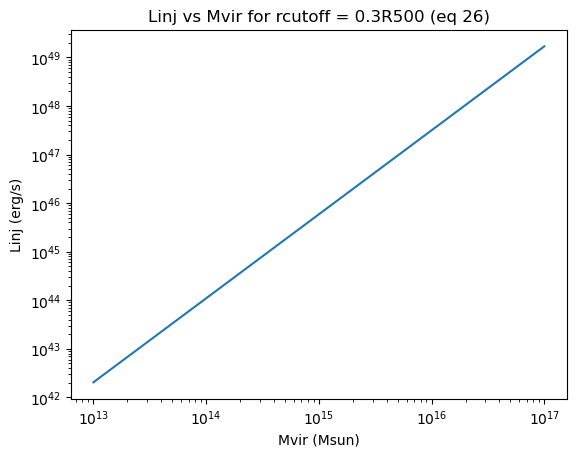

In [17]:
plt.loglog(Ms, Linj(Ms))
plt.xlabel("Mvir (Msun)")
plt.ylabel("Linj (erg/s)")
plt.title("Linj vs Mvir for rcutoff = 0.3R500 (eq 26)")

In [19]:
heating_rates = [nfw.vol_heating_rate([nfw.R500], 
                                      Linj(nfw.Mvir),
                                      0.3*nfw.R500) for nfw in nfws]

In [72]:
cooling_rates = [nfw.vol_cooling_rate([nfw.R500.value]*u.Mpc) for nfw in nfws]

In [71]:
nfws[0].vol_cooling_rate([nfws[0].R500.value]*u.Mpc)

<Quantity [6.90661325e-31] erg / (cm3 s)>

In [79]:
heating_rates_01 = [nfw.vol_heating_rate([0.1*nfw.R500], 
                                      Linj(nfw.Mvir),
                                      0.3*nfw.R500) for nfw in nfws]
cooling_rates_01 = [nfw.vol_cooling_rate([0.1*nfw.R500.value]*u.Mpc) for nfw in nfws]

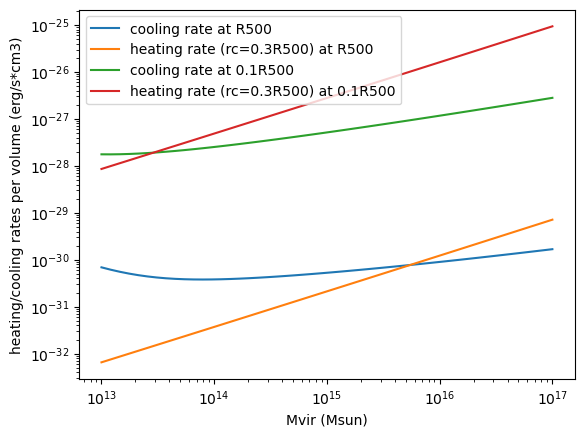

In [82]:
plt.loglog(Ms, cooling_rates, label="cooling rate at R500")
plt.loglog(Ms, heating_rates, label="heating rate (rc=0.3R500) at R500")
plt.loglog(Ms, cooling_rates_01, label="cooling rate at 0.1R500")
plt.loglog(Ms, heating_rates_01, label="heating rate (rc=0.3R500) at 0.1R500")
plt.xlabel("Mvir (Msun)")
plt.ylabel("heating/cooling rates per volume (erg/s*cm3)")
plt.legend(loc="upper left")

In [103]:
total_heating_rates = [nfw.total_heating_rate(0.015*nfw.R500, nfw.R500, 
                                      Linj(nfw.Mvir),
                                      0.3*nfw.R500).value for nfw in nfws]

In [104]:
total_cooling_rates = [nfw.total_cooling_rate(0.015*nfw.R500, nfw.R500).value for nfw in nfws]

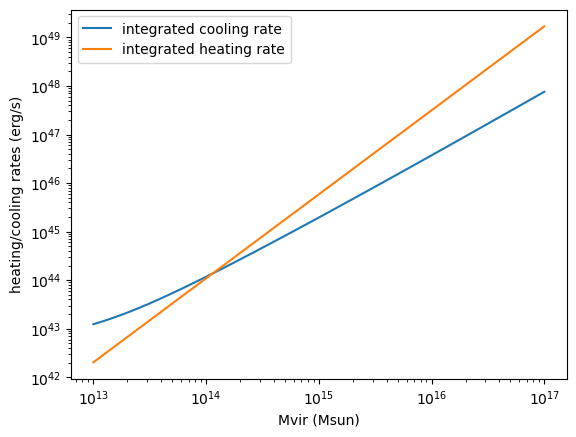

In [105]:
plt.loglog(Ms, total_cooling_rates, label="integrated cooling rate")
plt.loglog(Ms, total_heating_rates, label="integrated heating rate")
plt.xlabel("Mvir (Msun)")
plt.ylabel("heating/cooling rates (erg/s)")
plt.legend()

In [ ]:
from cluster_functions import c
def vol_dm_cooling_rate(T_b, cluster, s0, m_chi, n=0, f_chi=1, m_psi=0.1*u.GeV):
    dm_temp = cluster.virial_temperature(m_chi, f_chi=f_chi, m_psi=m_psi)
    uth = np.sqrt(T_b / cluster.m_b + dm_temp / m_chi)
    rho_chi = cluster.rho_dm * f_chi

    denominator = (m_chi + cluster.m_b) ** 2
    numerator = (
            3
            * (T_b - dm_temp)
            * rho_chi
            * const.m_p
            * c(n)
            * uth ** (n + 1)
            * (const.c.to(u.cm / u.s))
            * s0
        
        )
    #conversion_factor = 0.197*1e-15 * (u.GeV * u.m)
    #print("dm cooling rate", (numerator / denominator).to(u.erg/u.s))
    return (numerator / denominator).to(u.erg/(u.s*u.cm**3)

In [ ]:
def virial_temperature(m_chi, f_chi=1, m_psi=0.1 * u.GeV, M500, R500):
    frac = f_chi / m_chi + (1 - f_chi) / m_psi
    M_kg = M500.to(u.kg, equivalencies=u.mass_energy())
    return (0.3 * const.G * M_kg / (R500 * frac) * 1 / const.c**2).to(u.GeV)

In [ ]:
mx = 1e-4*u.GeV
